<a href="https://colab.research.google.com/github/jacobwmorgan/champignons/blob/main/champignons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Mushrooms using Machine Learning


In [1]:
!pip install -q kaggle
!pip install -q tensorflow

## Dataset handling

Later on I will create my own dataset, but for now im just using [the one I found on kaggle](https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images?resource=download) 

[How to create a dataset](https://github.com/Kaggle/kaggle-api#create-a-new-dataset) <br>
[Update dataset](https://github.com/Kaggle/kaggle-api#create-a-new-dataset-version) <br>


[Kaggle and google Colab](https://www.kaggle.com/general/51898)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content/drive/MyDrive/Champignons/.kaggle/"

In [4]:
%cd /content/drive/MyDrive/Champignons/

/content/drive/MyDrive/Champignons


### Downloading dataset

In [5]:
import kaggle
import shutil
kaggle.api.authenticate()

if os.path.exists("./Mushrooms") != True:
  print("Downloading dataset ...")
  kaggle.api.dataset_download_files("maysee/mushrooms-classification-common-genuss-images ", unzip = True)
  shutil.rmtree("./mushrooms")
else:
  print("Dataset already in working directory")

Dataset already in working directory


### Preprocessing dataset

Splitting into train, validate and test

In [6]:

os.chdir("/content/drive/MyDrive/Champignons")

dataset_location = "/content/drive/MyDrive/Champignons/Mushrooms"
training_per, validation_per  = 0.75,0.9

if os.path.exists("/content/drive/MyDrive/Champignons/temp") != True:
  print("Temp doesnt exist")
  print("Generating temp directorys for \n -> train \n -> valid \n -> test")
  os.mkdir("./temp")
  os.mkdir("./temp/train")
  os.mkdir("./temp/valid")
  os.mkdir("./temp/test")

  temp_directory = "/content/drive/MyDrive/Champignons/temp"

  for fungi in os.listdir(dataset_location):
    original_path = f"{dataset_location}/{fungi}"
    original_data = os.listdir(original_path)

    n_samples = len(original_data)
    n_training = int(n_samples * training_per)
    n_validation = int(n_samples * validation_per)

    os.mkdir(f"{temp_directory}/train/{fungi}")
    for image in range(n_training):
      image = original_data[image]
      o_file = f"{original_path}/{image}"
      new_file = f"{temp_directory}/train/{fungi}/{image}"
      shutil.copyfile(o_file,new_file)
    
    os.mkdir(f"{temp_directory}/valid/{fungi}")
    for image in range(n_training,n_validation):
      image = original_data[image]
      o_file = f"{original_path}/{image}"
      new_file = f"{temp_directory}/valid/{fungi}/{image}"
      shutil.copyfile(o_file,new_file)

    os.mkdir(f"{temp_directory}/test/{fungi}")
    for image in range(n_validation,n_samples):
      image = original_data[image]
      o_file = f"{original_path}/{image}"
      new_file = f"{temp_directory}/test/{fungi}/{image}"
      shutil.copyfile(o_file,new_file)
else:
  print("Temp files exist, your good to go")


Temp files exist, your good to go


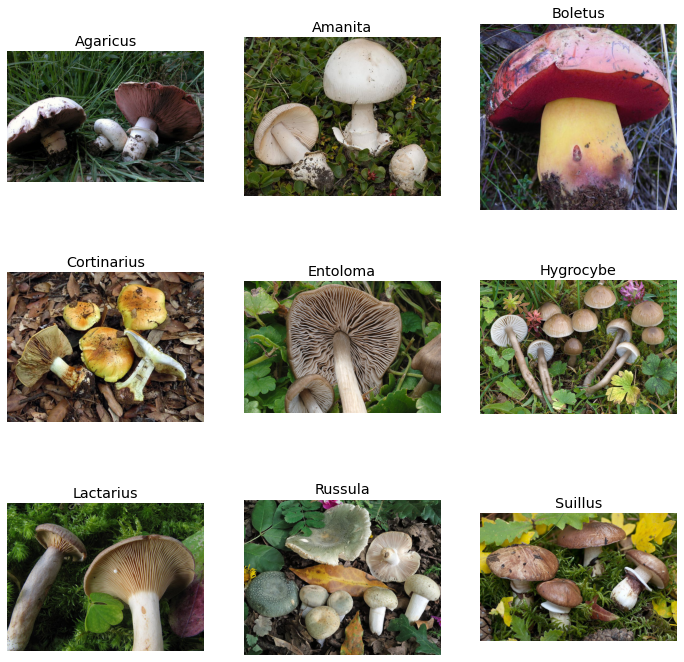

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as matplotimage
import random
%matplotlib inline

plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})
pos = 0

for fungi in os.listdir(dataset_location):
  imageIndex = random.randint(0,len(os.listdir(os.path.join(dataset_location,fungi))))
  image = os.listdir(os.path.join(dataset_location,fungi))[imageIndex]
  figure = plt.gcf()
  figure.set_size_inches(3 * 4, 3 * 4)
  pos += 1
  sp = plt.subplot(3,3, pos)

  curated_image = matplotimage.imread(os.path.join(dataset_location,fungi,image))
  plt.imshow(curated_image)
  plt.title(fungi)
  plt.axis("Off")

### Splitting into tensor flow

[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input #Research into more preprocessing settings for tensorflow , specficall the one from that paper

#Hardware optimisation
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth
hardware_devices = list_physical_devices('GPU')
print(f'Number of GPUs available: {len(hardware_devices)}')

if len(hardware_devices) > 0:
  set_memory_growth(hardware_devices[0],True)

# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE #What is this ?
IMG_SIZE = 299
BATCH_SIZE = 64


training = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory = "/content/drive/MyDrive/Champignons/temp/train",
                                                                                             target_size =(IMG_SIZE,IMG_SIZE),
                                                                                             class_mode = "categorical",
                                                                                             batch_size = BATCH_SIZE,
                                                                                             shuffle = True)
validation = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory = "/content/drive/MyDrive/Champignons/temp/valid",
                                                                                             target_size =(IMG_SIZE,IMG_SIZE),
                                                                                             class_mode = "categorical",
                                                                                             batch_size = BATCH_SIZE,
                                                                                             shuffle = True)
                                                                                            
testing = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(directory = "/content/drive/MyDrive/Champignons/temp/test",
                                                                                             target_size =(IMG_SIZE,IMG_SIZE),
                                                                                             class_mode = "categorical",
                                                                                             batch_size = BATCH_SIZE,
                                                                                             shuffle = True)



Number of GPUs available: 1
Found 5033 images belonging to 9 classes.
Found 1005 images belonging to 9 classes.
Found 676 images belonging to 9 classes.


## Creating a model using tensor flow
[Inception_v3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3) <br>
Im using inception since the paper im looking at uses it and says its the best

In [9]:

model = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='avg')


In [10]:
model = tf.keras.models.Sequential(
    [
      model,
      tf.keras.layers.Dense(9,activation = "softmax")
    ]
)

model.layers[0].trainable = False
model.compile(loss='categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy']) #Research more about these variables , which one is the best etc, read more about this
model.summary()

# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 9)                 11529     
                                                                 
Total params: 4,061,100
Trainable params: 11,529
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True #fixes the error

history = model.fit(training,
                        validation_data=validation,
                        epochs=5, #100
                        steps_per_epoch=79, #79
                        validation_steps=16, #16
                        verbose=2,
                        callbacks=[reduce_lr, early_stop],
                        use_multiprocessing=True,
                        workers=1)

#https://www.kaggle.com/code/ekaterinadranitsyna/mushroom-images-classification/notebook

Epoch 1/5
79/79 - 2916s - loss: 1.5398 - accuracy: 0.4860 - val_loss: 1.3238 - val_accuracy: 0.5542 - lr: 0.0010 - 2916s/epoch - 37s/step
Epoch 2/5
79/79 - 139s - loss: 1.0358 - accuracy: 0.6871 - val_loss: 1.1066 - val_accuracy: 0.6677 - lr: 0.0010 - 139s/epoch - 2s/step
Epoch 3/5
79/79 - 123s - loss: 0.8537 - accuracy: 0.7481 - val_loss: 0.9984 - val_accuracy: 0.6816 - lr: 0.0010 - 123s/epoch - 2s/step
Epoch 4/5
79/79 - 125s - loss: 0.7501 - accuracy: 0.7791 - val_loss: 0.9259 - val_accuracy: 0.7045 - lr: 0.0010 - 125s/epoch - 2s/step
Epoch 5/5
79/79 - 138s - loss: 0.6807 - accuracy: 0.8021 - val_loss: 0.8685 - val_accuracy: 0.7264 - lr: 0.0010 - 138s/epoch - 2s/step
